In [29]:
# auto reload libraries (you do need to re-import libraries if you make changes)
%load_ext autoreload
%autoreload 2

# base 
import pandas as pd
import numpy as np
from pprint import pprint
import os

# preprocessing 
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import SimpleImputer, IterativeImputer,KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import TruncatedSVD

# models
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# own defined functions/classes 
from preprocessing.preprocess_pipe import MakeLowerCase
from preprocessing.preprocess_pipe import HdResolutionCategorizer
from preprocessing.preprocess_pipe import StorageCategorizer
from preprocessing.preprocess_pipe import SsdCategorizer

from preprocessing.preprocess_pipe import print_missing
from preprocessing.preprocess_pipe import calculate_perf
from preprocessing.preprocess_pipe import custom_scoring_func

from modelling.weight_samples import weights_samples

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# global parameters
pd.set_option('display.max_columns', 500)

# set working directory
uppath = lambda _path, n: os.sep.join(_path.split(os.sep)[:-n])
__file__ = 'C:\\Users\\Pieter-Jan\\Documents\\KuLeuven\\Semester2\\AA\\AAForB_Assignment2\\code\\PieterJan'
out = uppath(__file__, 2)
os.chdir(out)
print(os.getcwd())

C:\Users\Pieter-Jan\Documents\KuLeuven\Semester2\AA\AAForB_Assignment2


## TODO

### PLEASE DEFINE FUNCTIONS IN SEPERATE FILES TO KEEP THE NOTEBOOK CLEAN

- Add custum scoring metric: **DONE**
- further integrate preprocessing steps from Arnaud **DONE**
- Integerate steps from Victor **Partly DONE**
- Look at comments of Victor for next steps
- Look at feature engineering ideas
- Integrate steps from Bram 
- Integrate custum scoring metric (also when performing the cross validation/grid search) **DONE**
- Make function that checkts whether prediction of the maximum price are >= predictions of the minimum price
- Investigate why there is such a huge difference between the performance on 'our test set' and the performance of submission test set
- Make function that saves trained models
- Try out other models (Boosting, Support Vector Machines, Penalized Linear models like lasso, stacked models ...)
- Implement better missing values imputations methods **DONE**
- Add some post processing visualizations:
    - feature importance plots
    - look at our predictions visually (do they make sense?)
    - look at the residuals
    - Have a look at this especially section 5 for model interpretability ideas
    https://christophm.github.io/interpretable-ml-book/pdp.html


# Step 1: import data and split in train and validation set
The validation set is more our own kind of test set

In [10]:
# read in trainig and validation data
# use the same data split as we did in R
df_all_train = pd.read_csv("data\\train.csv", sep=',')
df_test = pd.read_csv("data\\test.csv", sep=',')

print(f'Dimensions of all training data {df_all_train.shape}')
print(f'Dimension test data {df_test.shape}')

Dimensions of all training data (510, 22)
Dimension test data (222, 20)


In [11]:
# split in training and validation set
df_train = df_all_train.sample(frac=0.75, random_state=0, replace=False)
df_val = df_all_train.drop(df_train.index)

# reset index, if you don't resit missing rows get inserted in the pipeline
# see: https://stackoverflow.com/questions/31323499/sklearn-error-valueerror-input-contains-nan-infinity-or-a-value-too-large-for
df_train = df_train.reset_index().drop('index',axis=1)
df_val = df_val.reset_index().drop('index',axis=1)

# Step 2: define pipeline

The pipeline should handle all steps performed on the data from data cleaning till the acutal model prediction. 
It should also be fairly easily to apply this to the test data. Therefore we make use of the scikit learn pipeline which allows all of this functionality. You can also implement your own `custom` transformations.

For more information on how to use and why using pipelines see:
 - https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf 
 - scikit learn api on pipelines: https://scikit-learn.org/stable/modules/compose.html
 - Scikit learn api for more preprocessing steps: https://scikit-learn.org/stable/modules/preprocessing.html#non-linear-transformation

We make a difference between the pre processing steps for
- numerical features
- categorical features

It's important to note that if a feature is in the numerical feature pipeline it can't be in the categorical feature pipeline. Also if some preprocessing steps in the numerical feature pipeline need features from the categorical pipeline you will get an error. All preprocessing steps in each pipeline should be able to perform the transformation only with the categorical or numerical features. 

You can implement some custom transformation steps like 'MakeLowerCase' ==> see preprocessing.preprocess_pipe for more details or check this article  these two article (also gives some explanation on how to implement pipelines)

- https://gist.github.com/amberjrivera/8c5c145516f5a2e894681e16a8095b5c

In [12]:
#Numerical features to pass down the numerical pipeline 
numerical_features = ['screen_size' ,'pixels_x','pixels_y',
                      'ram', 'weight','ssd','storage']

#Categrical features to pass down the categorical pipeline 
categorical_features = ['brand','base_name', 'screen_surface','touchscreen',
                        'cpu','cpu_details','detachable_keyboard',
                        'discrete_gpu','gpu', 'os','os_details']

# define all unique features
features = np.unique(numerical_features).tolist() + np.unique(categorical_features).tolist()

# target variables
target = ['min_price','max_price']

In [13]:
# train
X_train = df_train[features]
y_train = df_train[target]

# validation (this is kind our own test set)
X_val  = df_val[features]
y_val = df_val[target]

# train_validation (this is all training data we have) for fitting the model
X_all_train = df_all_train[features]
y_all_train = df_all_train[target]

# test
X_test = df_test[features]

In [14]:
# you can add many more and 
# you can even define custom preprocessing steps like 'MakeLowerCase()'

# pipeline  uses only numerical features,
numeric_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    #('imputer', KNNImputer(n_neighbors=5, weights='uniform',metric='nan_euclidean')),
    ('imputer', IterativeImputer(missing_values=np.nan, random_state=0, n_nearest_features=None, sample_posterior=True)),
    #('transformation', PowerTransformer(method='yeo-johnson',standardize=False)),
     #Scale features using statistics that are robust to outliers.
    ('scaler', RobustScaler(with_centering=True, with_scaling=True, quantile_range=(10.0, 90.0)))]) 

# pipeline use only categorical features
categorical_transformer = Pipeline(steps=[ 
    ('lowercase', MakeLowerCase()), # lower cases all columns containing strings
    #('sd_category' ,SsdCategorizer(drop_original_feature=True)),
    #('storage_category', StorageCategorizer(drop_original_feature=True)),
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# add both preprocessing pipelines in one pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

In [8]:
# this is how the preporcessed pipeline looks like (just to have an idea)
pd.DataFrame(preprocessor.fit_transform(X_train)).shape

(382, 1)

### Give more weights to higher priced computers

Sum weights: 1.0
0    0.001762
1    0.005480
2    0.009748
3    0.000113
4    0.000113
Name: max_price, dtype: float64
   min_price  max_price
0     849.99     849.99
1    1382.99    1498.97
2    1999.11    1999.11
3     179.68     214.99
4     199.99     214.90


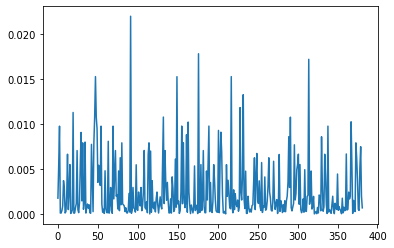

In [31]:
weights_train = weights_samples(df=y_train.iloc[:,1], order=2, plot_weights=True)
print(weights_train.head())
print(y_train.head())

# Step 3: add models to pipeline

Possible to fit multiple target variabels, so you **don't** need to fit a different models for min. price and max. price

### A) Training and parameter tuning

##### 1) Automatic tuning via grid search

In [16]:
# define model: I just add some default parameters but you could
# also just write: RandomForestRegressor() since we will perform a grid search 
# to find good hyperparameter values
model_rf = RandomForestRegressor(random_state=1, criterion='mae')

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(model_rf.get_params())

# add to pipeline
pipeline_rf = Pipeline(memory=None,
              steps=[('preprocessor', preprocessor),
                     ('regressor', model_rf)])


# add transformation on the target variable, by default power transformation 
# also performs standardization after performing the power transformation
# and back transform to the original space when outputting predictions 
transformer_target = PowerTransformer(method='yeo-johnson',standardize=True)
pipeline_rf_update = TransformedTargetRegressor(regressor=pipeline_rf, 
                                         transformer=transformer_target)

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mae',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


In [17]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 500, stop = 4000, num = 20)]

# The number of features to consider when looking for the best split:
# - If “auto”, then max_features=n_features.
# - If “sqrt”, then max_features=sqrt(n_features).
# - If “log2”, then max_features=log2(n_features).
# - If None, then max_features=n_features
max_features = ['auto', 'sqrt','log2',None]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(20, 200, num = 20)]
max_depth.append(None)

# The function to measure the quality of a split
criterion = ['mse','mae']

# Minimum number of samples required to split a node
# - If int, then consider min_samples_split as the minimum number.
# - If float, then min_samples_split is a fraction and ceil(min_samples_split * n_samples) are the minimum number of samples for each split.
min_samples_split = [0.001, 0.01, 0.025, 0.05]
# Minimum number of samples required at each leaf node

# - If int, then consider min_samples_leaf as the minimum number.
# - If float, then min_samples_leaf is a fraction and ceil(min_samples_leaf * n_samples) are the minimum number of samples for each node.
min_samples_leaf = [0.001, 0.01, 0.025, 0.05,]

# Create the random grid
random_grid_rf = {
   'regressor__regressor__n_estimators': n_estimators,
   'regressor__regressor__max_features': max_features,
   'regressor__regressor__max_depth': max_depth,
   'regressor__regressor__criterion': criterion,
   'regressor__regressor__min_samples_split': min_samples_split,
   'regressor__regressor__min_samples_leaf': min_samples_leaf}

#### Helpful articles:
 - custom scoring metric: https://stackoverflow.com/questions/48468115/how-to-create-a-customized-scoring-function-in-scikit-learn-for-scoring-a-set-of
 - random parameter search: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
you can also use the traditional grid search in pyhton, but I prefer the randomizedSearch
 - Once the optimal parameters are found for the model, you don't need to run this again

In [13]:
# define random search (and narrow down time grid search)
rf_random_search = RandomizedSearchCV(
   estimator = pipeline_rf_update, 
   param_distributions = random_grid_rf, n_iter = 10,
   cv = 10, verbose=2, random_state=1, n_jobs = -1, refit=True,
   scoring=make_scorer(custom_scoring_func, greater_is_better=False)
)


# run grid search and refit with best hyper parameters
rf_random_search.fit(X_train, y_train, regressor__sample_weight=weights_train.values)  
print(rf_random_search.best_params_)    
print(rf_random_search.best_score_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 35.6min finished


{'regressor__regressor__n_estimators': 2710, 'regressor__regressor__min_samples_split': 0.001, 'regressor__regressor__min_samples_leaf': 0.001, 'regressor__regressor__max_features': 'log2', 'regressor__regressor__max_depth': 105, 'regressor__regressor__criterion': 'mse'}
-322.34051194848496


- **TODO make a plot that visualizes hyperparameters (maybe kind of heatmap)**
- Once we have found good tuning parameters write them down so we don't need to redo this step over and over

In [14]:
# have look at the best hyperparameters and their respective performance (maybe also look at the sd)
pd.DataFrame(rf_random_search.cv_results_).sort_values(
    by=['mean_test_score'],ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__regressor__n_estimators,param_regressor__regressor__min_samples_split,param_regressor__regressor__min_samples_leaf,param_regressor__regressor__max_features,param_regressor__regressor__max_depth,param_regressor__regressor__criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
1,19.734628,0.138906,0.591621,0.030785,2710,0.001,0.001,log2,105,mse,"{'regressor__regressor__n_estimators': 2710, '...",-289.631246,-465.485011,-303.718647,-266.545772,-354.677080,-373.423335,-296.831226,-379.603491,-280.613506,-212.875805,-322.340512,68.065128,1
8,12.117126,0.105683,0.154724,0.017286,500,0.001,0.001,None,171,mse,"{'regressor__regressor__n_estimators': 500, 'r...",-252.723388,-504.014058,-252.973044,-283.994592,-323.875343,-396.985183,-318.068287,-370.995717,-312.938195,-220.323957,-323.689176,79.102106,2
0,385.563410,21.233932,0.226443,0.015105,1052,0.025,0.001,None,57,mae,"{'regressor__regressor__n_estimators': 1052, '...",-268.129670,-519.313008,-256.066709,-304.943608,-324.857190,-411.401452,-325.113176,-380.452856,-327.059175,-221.129810,-333.846665,81.668061,3
6,30.298808,0.225224,0.660829,0.041712,2894,0.025,0.01,auto,76,mse,"{'regressor__regressor__n_estimators': 2894, '...",-248.381263,-483.564308,-279.175072,-288.197911,-372.670945,-421.771150,-327.020882,-389.673498,-327.368570,-228.357551,-336.618115,76.345842,4
2,30.267952,2.501001,0.615276,0.070752,2710,0.05,0.001,auto,57,mse,"{'regressor__regressor__n_estimators': 2710, '...",-280.352882,-505.884861,-259.670129,-288.331555,-353.300823,-428.157523,-339.889836,-386.387550,-332.850476,-239.610223,-341.443586,77.721904,5


##### Performance on validation data

In [15]:
calculate_perf(y_val, rf_random_search.predict(X_val))

{'minimum price': 118.34875310317854,
 'maximum price': 118.171516358394,
 'total error': 236.52026946157252}

##### 2) Manual parameters tuning

In [25]:
# train your final model on all data with best parameters 
model_rf = RandomForestRegressor(
     criterion='mse',
     n_estimators=2710, 
     max_depth=105,
     max_features='log2',
     min_samples_split=0.001,
     min_samples_leaf=0.001,
     bootstrap=False,
     n_jobs=-1
)
# add to pipeline
pipeline_rf = Pipeline(memory=None,
              steps=[('preprocessor', preprocessor),
                     ('regressor', model_rf)],
              verbose=True)

# again add transformer for target variable
pipeline_rf = TransformedTargetRegressor(regressor=pipeline_rf, 
                                         transformer=transformer_target)

# fit final model on all training data we have at hand
weights_train = weights_samples(y_train.iloc[:,1], order=2)
pipeline_rf = pipeline_rf.fit(X_train, y_train, regressor__sample_weight=weights_train.values)

Sum weights: 1.0
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.4s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=  12.9s


In [26]:
# performance on data where the model was fit one (should be very low)
calculate_perf(pipeline_rf.predict(X_train), y_train)

{'minimum price': 0.2076331524092512,
 'maximum price': 0.33023741656533095,
 'total error': 0.5378705689745822}

##### Performance on validation data

In [27]:
# performance on validation data
calculate_perf(y_val, pipeline_rf.predict(X_val))

{'minimum price': 115.71289992460083,
 'maximum price': 116.83948739440535,
 'total error': 232.5523873190062}

### C) Post processing

 - inspect predictions/residuals (make visualisations) (See Bram)
 - feature importance (see Bram)

### D) Predictions test data

Refit on all training data (using the parameters found on the random search) and submit prediction

In [32]:
# train your final model on all data with best parameters 
model_rf_final = RandomForestRegressor(
     criterion='mse',
     n_estimators=2710, 
     max_depth=105,
     max_features='log2',
     min_samples_split=0.001,
     min_samples_leaf=0.001,
     bootstrap=True,
     n_jobs=-1
)
# add to pipeline
pipeline_rf_final = Pipeline(memory=None,
              steps=[('preprocessor', preprocessor),
                     ('regressor', model_rf_final)],
              verbose=True)

# again add transformer for target variable
pipeline_rf_final = TransformedTargetRegressor(regressor=pipeline_rf_final, 
                                         transformer=transformer_target)

# fit final model on all training data we have at hand
weights_all_train = weights_samples(y_all_train.iloc[:,1], order=0)
pipeline_rf_final = pipeline_rf_final.fit(X_all_train, y_all_train)

Sum weights: 1.0
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.4s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=  14.9s


In [33]:
# performance on all data where the model was fit one (should be very low)
calculate_perf(pipeline_rf_final.predict(X_all_train), y_all_train)

{'minimum price': 54.97494672991178,
 'maximum price': 56.611127623141755,
 'total error': 111.58607435305353}

In [35]:
# make predictions on test data
rf_pred_test = pipeline_rf_final.predict(X_test)

# submission format
rf_submission_format = pd.DataFrame.from_dict(
 {'ID':df_test['id'].values,
 'MIN':rf_pred_test[:,0],
 'MAX':rf_pred_test[:,1]}).set_index('ID')

# write to csv
rf_submission_format.to_csv('code\\PieterJan\\output\\submission\\rf_python.csv' ,
                            header=True, index=True, sep=',')